In [1]:
import gzip
import numpy as np
import struct as st
import matplotlib.pyplot as plt
import time
import copy
from sklearn.svm import SVC
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler

First we need to import our data. The data is stored in idx3-ubyte files. Thank you [Siladittya Manna](https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1) for the information on wrangling this data. The format for the image files is shown below.

|[offset] | [type] | [value] | [description]|
|------|------|------|------|
| 0000 | 32 bit integer | 0x00000803(2051)| magic number|
| 0004 | 32 bit integer | 60000 | number of images |
| 0008 | 32 bit integer | 28 | number of rows|
| 0012 | 32 bit integer | 28 | number of columns| 
| 0016 | unsigned byte  | ?? | pixel |
| 0017 | unsigned byte  | ?? | pixel |

And the format for the label files is shown below.

|[offset] | [type] | [value] | [description]|
|------|------|------|------|
| 0000 | 32 bit integer | 0x00000803(2051)| magic number|
| 0004 | 32 bit integer | 60000 | number of items |
| 0016 | unsigned byte  | ?? | pixel |
| 0017 | unsigned byte  | ?? | pixel |

In [2]:
filename = {'images' : 'data/train-images-idx3-ubyte' ,'labels' : 'data/train-labels-idx1-ubyte'}

#Open the images IDX file in readable binary mode.
with open(filename['images'],'rb') as train_imagesfile:
    train_imagesfile.seek(0)
    # Read the magic number and the dimensions of the image data-set
    magic = st.unpack('>4B',train_imagesfile.read(4))
    n_img = st.unpack('>I',train_imagesfile.read(4))[0] #num of images
    n_rows = st.unpack('>I',train_imagesfile.read(4))[0] #num of rows
    n_col = st.unpack('>I',train_imagesfile.read(4))[0] #num of column
    
    # read image data into images_array
    nBytesTotal = n_img*n_rows*n_col*1 #since each pixel data is 1 byte
    train_images = 255 - np.asarray(st.unpack('>'+'B'*nBytesTotal,train_imagesfile.read(nBytesTotal))).reshape((n_img,n_rows,n_col))

In [3]:
with open(filename['labels'],'rb') as train_labels_file:
    train_labels_file.seek(0)
    # Read the magic number and the dimensions of the image data-set
    magic = st.unpack('>4B',train_labels_file.read(4))
    n_img = st.unpack('>I',train_labels_file.read(4))[0] #num of images

    # read label data into label array
    nBytesTotal = n_img*1 #since each label is 1 byte
    train_labels = np.asarray(st.unpack('>'+'B'*nBytesTotal,train_labels_file.read(nBytesTotal))).reshape((n_img,1))

Let us see how our numbers look

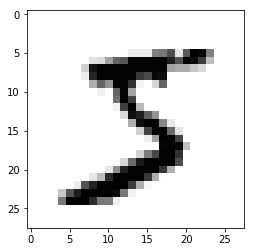

In [4]:
for image in train_images:
    # Plot
    plt.imshow(image, cmap='gray')
    plt.show()
    time.sleep(2)
    break # I only want to see one for now. comment to loop through entire training set 
    clear_output()

We will need to flatten our data as it is currently stored as $28 \times 28$ numpy array.

In [ ]:
# make copy and flatten data
train_images_array = train_images.reshape(train_images.shape[0], 28*28).astype(np.float)
train_labels_array = train_labels.flatten()

Before training the SVM's that will be used to classify the number, we will need to do some preprocessing. SVM's are sensitive to the scaling of the data as it is attempting to maximize the margin of the seperating hyperplane. We will scale our data so that each feature vector in the training data is centered with variance 1. ScitKit learn has a useful standard scaler class that we will utilize. 

In [6]:
# fit scaler and scale data
scaler = StandardScaler()
train_images_array = scaler.fit_transform(train_images_array)

The type of multiclass SVM that will be used here is a one versus one strategy for the decision function with a radial basis function kernel. SciKitLearn has implemented a multiclass SVM that can be set to run as desired.

In [7]:
MNIST_SVM = SVC(kernel='rbf', decision_function_shape='ovo')
MNIST_SVM.fit(train_images_array, train_labels_array)

# # subset to train faster for testing, first 1000 training examples
# MNIST_SVM = SVC(kernel='rbf', decision_function_shape='ovo')
# MNIST_SVM.fit(train_images_array[:1000], train_labels_array[:1000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

With our model we can now make predictions and measure the resulting test error.
First we will load the test data just as we did with the training data.

In [8]:
filename = {'images' : 'data/t10k-images-idx3-ubyte' ,'labels' : 'data/t10k-labels-idx1-ubyte'}

#Open the images IDX file in readable binary mode.
with open(filename['images'],'rb') as test_imagesfile:
    test_imagesfile.seek(0)
    # Read the magic number and the dimensions of the image data-set
    magic = st.unpack('>4B',test_imagesfile.read(4))
    n_img = st.unpack('>I',test_imagesfile.read(4))[0] #num of images
    n_rows = st.unpack('>I',test_imagesfile.read(4))[0] #num of rows
    n_col = st.unpack('>I',test_imagesfile.read(4))[0] #num of column
    
    # read image data into images_array
    nBytesTotal = n_img*n_rows*n_col*1 #since each pixel data is 1 byte
    test_images = 255 - np.asarray(st.unpack('>'+'B'*nBytesTotal,test_imagesfile.read(nBytesTotal))).reshape((n_img,n_rows,n_col))
    
# make copy and flatten + scale data
test_images_array = test_images.reshape(test_images.shape[0], 28*28).astype(np.float)
test_images_array = scaler.fit_transform(test_images_array)

In [9]:
with open(filename['labels'],'rb') as test_labels_file:
    test_labels_file.seek(0)
    # Read the magic number and the dimensions of the image data-set
    magic = st.unpack('>4B',test_labels_file.read(4))
    n_img = st.unpack('>I',test_labels_file.read(4))[0] #num of images

    # read label data into label array
    nBytesTotal = n_img*1 #since each label is 1 byte
    test_labels = np.asarray(st.unpack('>'+'B'*nBytesTotal,test_labels_file.read(nBytesTotal))).reshape((n_img,1))
    
test_labels_array = test_labels.flatten()

Let us view the first ten test images and their predictions.

In [12]:
for index, image in enumerate(test_images[:10]):
    # Plot
    plt.imshow(image, cmap='gray')
    plt.show()
    print("Predicted: {}".format(MNIST_SVM.predict([test_images_array[index]])))
    print("Actual: {}".format(test_labels_array[index]))
    time.sleep(2)
    clear_output()

We can also view the score, which is the mean accuracy of the prediction on the test data.

In [13]:
MNIST_SVM.score(test_images_array, test_labels_array)

0.9657